In [ ]:
# Dependencies
import pandas as pd
import numpy as np
import gmaps
import requests
from config import gkey
from config import ow_key
import time
import pprint
import pyowm
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt

In [ ]:
owm = pyowm.OWM(ow_key)
mgr = owm.agro_manager()
from pyowm.utils.geo import Polygon as GeoPolygon
mgr = owm.agro_manager()
# Configure gmaps
gmaps.configure(api_key=gkey)

In [ ]:
wine_data = "winemag-data_first150k.csv"
wine_df = pd.read_csv(wine_data)
wine_df.head()

In [ ]:
wine_df2=wine_df.drop(columns= ["Unnamed: 0","region_2"], axis=1)
wine_df2.head()

In [ ]:
dropped_wine= wine_df2.dropna()
dropped_wine.count()

In [ ]:
us_data=dropped_wine[dropped_wine["country"]=="US"]
us_data

In [ ]:
target_area = (us_data["region_1"]+","+us_data["province"])

In [ ]:
unique_variety =us_data["variety"]
#unique_variety
unique_regions =us_data["region_1"].unique()
#unique_regions

In [ ]:
ratings = us_data["points"]

In [ ]:
wv = pd.DataFrame({"Location": target_area,"Wine Variety": unique_variety})
wv = pd.DataFrame({"Location": target_area,"Wine Ratings": ratings})
wv_group = wv.groupby("Location")
num_varieties = pd.DataFrame(wv_group["Wine Ratings"].mean()).reset_index()
#just sampling for testing purposes
sample_num_varieties = num_varieties.sample(200)
sample_num_varieties
num_varieties.count()

In [ ]:
# create a params dict that will be updated with new city each iteration
params = {"key": gkey}
base_url = "https://maps.googleapis.com/maps/api/geocode/json"
# Loop through the locations and run a lat/long search for each city
for idx, row in sample_num_varieties.iterrows():
#    print(idx)
    sample_target = row["Location"]
    # update address key value
    params['address'] = f"{sample_target}"
    # make request
    location_lat_lng = requests.get(base_url, params=params)
    # convert to json
    location_lat_lng = location_lat_lng.json()
    lat_long_geo = location_lat_lng["results"][0]["geometry"]
    try:
        latitude = lat_long_geo["location"]["lat"]
        longitude = lat_long_geo["location"]["lng"]
        
        
        north = latitude  + 0.01
        south = latitude  - 0.01
        east =  longitude + 0.01
        west =  longitude - 0.01
        
        try:
            gp = GeoPolygon([[
                [east, north],
                [west, north],
                [west, south],
               [east, south],
                [east, north]]])
            polygon = mgr.create_polygon(gp, 'my new shiny polygon')
            try:
                soil = mgr.soil_data(polygon) 
                sample_num_varieties.loc[idx, "Lat"] = latitude
                sample_num_varieties.loc[idx, "Lng"] = longitude  
                sample_num_varieties.loc[idx, "Soil Temperature (C) at 10 cm depth"] = soil.ten_cm_temp(unit='celsius') 
                sample_num_varieties.loc[idx, "Soil Moisture"] = soil.moisture
            except(AssertionError):
                continue
        except( pyowm.exceptions.OWMError ):
            continue
    except(KeyError, IndexError):
        print("Missing field/result... skipping.")
        continue
    time.sleep(3)
# Visualize to confirm lat lng appear
sample_num_varieties = sample_num_varieties.dropna()

In [24]:
sample_num_varieties.count()

Location                               19
Wine Ratings                           19
Lat                                    19
Lng                                    19
Soil Temperature (C) at 10 cm depth    19
Soil Moisture                          19
dtype: int64

In [13]:
sample_num_varieties.to_csv("Wine_Soil.csv")

In [14]:
post_process = pd.read_csv("Wine_Soil.csv")               

In [16]:
pnas_df = pd.read_csv("PNAS_Data/PNAS.csv")
pnas_df.head(100)

,latitude,longitude,spp_richness,N_dep_kghayr,precip_mm,temp_C_ave,pH,CL_kghayr_lower,CL_kghayr_upper,CL_kghayr,EX_kghayr,two_class_veg,NVC_1_name,NVC_2_name,NVC_Alliance,proj_orig
0,46.1,-83.7,15,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
1,46.1,-83.7,11,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
2,46.1,-83.7,12,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
3,46.1,-83.7,17,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
4,46.1,-83.7,16,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
5,46.1,-83.7,12,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
6,45.7,-86.6,25,5.72,732.15,5.98,7.0,8.85,9.22,9.03,-3.31,open_canopy,Shrubland,Evergreen shrubland,Juniperus communis Shrubland Alliance,Alvar
7,45.3,-83.6,19,8.89,751.28,6.67,7.3,8.98,9.35,9.16,-0.27,open_canopy,Shrubland,Evergreen shrubland,Juniperus communis Shrubland Alliance,Alvar
8,46.0,-83.7,15,8.63,782.47,5.69,7.2,15.86,19.38,17.43,-8.81,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
9,46.1,-84.9,17,7.94,822.37,5.05,5.6,13.08,15.04,13.96,-6.02,closed_canopy,Forest,Evergreen forest,Pinus strobus Forest Alliance,Alvar


In [17]:
pnas_group = pnas_df.groupby(["latitude","longitude"]).mean()
pnas_group = pnas_group.reset_index()

In [23]:
pnas_reduced = pnas_group[["latitude","longitude","precip_mm","temp_C_ave","pH"]]
pnas_reduced.count()

latitude      3739
longitude     3739
precip_mm     3739
temp_C_ave    3739
pH            3739
dtype: int64

In [19]:
pnas_dat_lat = pnas_reduced["latitude"]
pnas_dat_lng = pnas_reduced["longitude"]


radians(pnas_dat_lat[0])

0.47647488579445196

In [20]:
dist=[]
R =6373
for idx, row in post_process.iterrows():
    wine_lat = radians(row["Lat"])
    wine_lng = radians(row["Lng"])
    
    for i in range(len(pnas_dat_lat)):
            dlon = radians(pnas_dat_lng[i]) - wine_lng
            dlat = radians(pnas_dat_lat[i]) - wine_lat

            a = (sin(dlat/2))**2 + cos(wine_lat) * cos(radians(pnas_dat_lat[i])) * (sin(dlon/2))**2 
            c = 2 * atan2( sqrt(a), sqrt(1-a) ) 
            distance = R * c 
            dist.append(distance)
            
    ind = np.argmin(dist)
    post_process.loc[idx, "Precipitation(mm)"] = pnas_reduced.iloc[ind,2]
    post_process.loc[idx, "Avg. Air Temp (C)"] = pnas_reduced.iloc[ind,3]
    post_process.loc[idx, "pH(Soil)"] = pnas_reduced.iloc[ind,4]
    dist=[]
   

In [21]:
post_process.columns

Index(['Unnamed: 0', 'Location', 'Wine Ratings', 'Lat', 'Lng',
       'Soil Temperature (C) at 10 cm depth', 'Soil Moisture',
       'Precipitation(mm)', 'Avg. Air Temp (C)', 'pH(Soil)'],
      dtype='object')

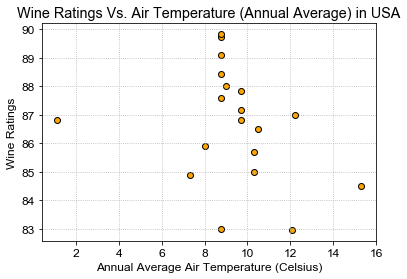

In [22]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
x1 = post_process["Avg. Air Temp (C)"]
y1 = post_process["Wine Ratings"]
plt.scatter(x1, y1, marker="o", facecolors="orange", edgecolors="black")
plt.title("Wine Ratings Vs. Air Temperature (Annual Average) in USA")
plt.xlabel("Annual Average Air Temperature (Celsius)")
plt.ylabel("Wine Ratings", fontname="Arial", fontsize=12)
plt.grid(linestyle='dotted')
plt.savefig("Ratings_Air_Temp.png",dpi=200)

In [ ]:
x1 = post_process["Precipitation(mm)"]
y1 = post_process["Wine Ratings"]
plt.scatter(x1, y1, marker="o", facecolors="lightblue", edgecolors="black")
plt.title("Wine Ratings Vs. Precipitation (Annual Average) in USA")
plt.xlabel("Annual Average Precipitation (mm)")
plt.ylabel("Wine Ratings")
plt.grid(linestyle='dotted')
plt.savefig("Ratings_Precip.png",dpi=200)

In [ ]:
x1 = post_process["pH(Soil)"]
y1 = post_process["Wine Ratings"]
plt.scatter(x1, y1, marker="o", facecolors="lightgreen", edgecolors="black")
plt.title("Wine Ratings Vs. pH(Soil) (Annual Average) in USA")
plt.xlabel("Annual Average pH of Soil")
plt.ylabel("Wine Ratings")
plt.grid(linestyle='dotted')
plt.savefig("Ratings_Soil_pH.png",dpi=200)


In [ ]:
x1 = post_process[" Soil Moisture"]
y1 = post_process["Wine Ratings"]
plt.scatter(x1, y1, marker="o", facecolors="lightcoral", edgecolors="black")
plt.title("Wine Ratings Vs. Soil Moisture in USA")
plt.xlabel("Soil Moisture (Volume Fraction) at 10 cm depth")
plt.ylabel("Wine Ratings")
plt.grid(linestyle='dotted')
plt.savefig("Ratings_Soil_Moisture.png",dpi=200)


In [ ]:
x1 = post_process[" Soil Temperature (C) at 10 cm depth"]
y1 = post_process["Wine Ratings"]
plt.scatter(x1, y1, marker="o", facecolors="pink", edgecolors="black")
plt.title("Wine Ratings Vs. Soil Temperature in USA")
plt.xlabel("Soil Temperature at 10 cm depth")
plt.ylabel("Wine Ratings")
plt.grid(linestyle='dotted')
plt.savefig("Ratings_Soil_Temp.png",dpi=200)
